<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/Lecture_3_high_dimensional_problems_and_sampling_algorithms_adelaide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emcee
!pip install dynesty
!pip install corner
!pip install dyplot
!pip install lalsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.4 MB 39.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████|

In [2]:
import numpy as np
import pylab as plt
plt.style.use('default')
from scipy.stats import norm
%matplotlib inline
from IPython.display import set_matplotlib_formats
from IPython.display import clear_output
set_matplotlib_formats('retina')

import scipy 
from matplotlib import rc

from scipy.interpolate import interp1d
import lal
import lalsimulation as lalsim

import sys



font = {'family' : 'sans serif',
        'weight': 'regular',
        'size'   : 10}

rc('font', **font)
#rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (0.4*8*1.9, 0.4*1.9*4*1.2)

# Lecture 3: high dimensional problems


* Scalability and high-dimensional models
    * The curse of dimensionality
* Parameter and evidence estimation for high-dimensional models
    * Posterior samples from nested sampling
    * Evidence estimates from nested sampling
* Model selection for high-dimension models
    * Using nested sampling to estimate the evidence and compute odds ratios

Uncertain masses and distance 

In [3]:
import pandas as pd



First we'll do some bookkeeping
1. Define a range of frequencies for our fake data
2. Generate some fake LIGO-like noise
3. Generate a fake signal and create data = signal + noise 

In [27]:
df = 1./4.
freqs = np.linspace(20,2048,int((2048-20)/df)+1)
psd = np.ones_like(freqs)
###################################################################################################
### This function draws random noise with the right statistics ###
### In the frequency domain, LIGO/Virgo noise has mean zero and variance proportional
### to the noise PSD (real and imag parts are identially and independently distributed) 
###################################################################################################

def GW_detector_noise():


  deltaF = 1/4.
  noise_mean = np.zeros_like(psd)
  for _i in range(len(psd)):
    psd[_i] = lalsim.SimNoisePSDaLIGOZeroDetLowPower(freqs[_i]) 

  noise_var = psd / (4*df) #see Lecture 1 

  noise_re = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var))
  noise_imag = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var))

  return noise_re + 1j*noise_imag



In [28]:
def frequency_domain_GWsignal(m1, m2, dist):
  
  longAscNodes = 0 # this is all book keeping
  eccentricity = 0 # Assume circular orbit
  meanPerAno = 0

  WFdict = lal.CreateDict()

  lalsim.SimInspiralWaveformParamsInsertFrameAxis(WFdict, 2)
  lalsim.SimInspiralWaveformParamsInsertPNSpinOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNTidalOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNPhaseOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertPNAmplitudeOrder(WFdict, -1)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda1(WFdict, 0.0)
  lalsim.SimInspiralWaveformParamsInsertTidalLambda2(WFdict, 0.0)
  
  approx = lalsim.IMRPhenomD
  
  s1 = [0.0, 0.0, 0.0]
  s2 = [0.0, 0.0, 0.0]
  #dist = 1500. # Distance in Mpc
  phi_c = 0. # Overall phase
  iota = 0
  f_high = freqs[-1]
  f_low= freqs[0]
  f_ref= 150
  hplus, hcross = lalsim.SimInspiralChooseFDWaveform(m1 * lal.MSUN_SI, 
                                                     m2 * lal.MSUN_SI,\
                                                     s1[0], s1[1], s1[2],\
                                                     s2[0], s2[1], s2[2],\
                                                     dist * 1e6 * lal.PC_SI, 
                                                     iota, phi_c,\
                                                     longAscNodes, 
                                                     eccentricity, meanPerAno,
                                                     df, f_low, f_high,
                                                     f_ref,\
                                                     WFdict, approx)
    
  hp = hplus.data.data[int(f_low/df):] # Data as numpy array
  hc = hcross.data.data[int(f_low/df):]
  
  
  return (hp+hc)

Now generate the noise, signal and data

In [50]:
noise = GW_detector_noise()

m1_true = 30 # solar masses
m2_true = 30 # solar masses
dist_true = 500 #mpc

signal_true =  frequency_domain_GWsignal(m1_true, m2_true, dist_true)

data = signal_true + noise

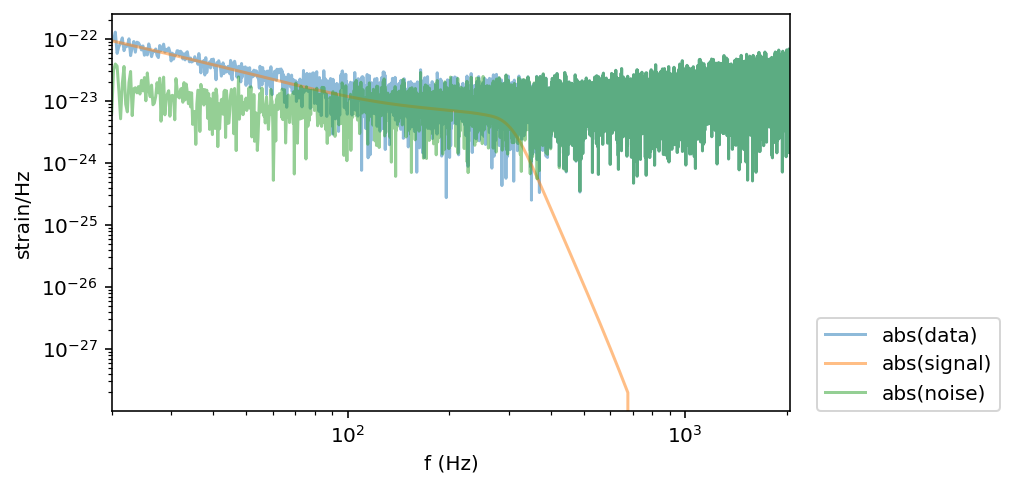

In [51]:
plt.loglog(freqs,np.absolute(data),label='abs(data)',alpha=0.5)
plt.loglog(freqs,np.absolute(signal_true),label='abs(signal)',alpha=0.5)
plt.loglog(freqs,np.absolute(noise),label='abs(noise)',alpha=0.5)

plt.xlabel('f (Hz)')
plt.ylabel('strain/Hz')
plt.xlim(20,2048)
plt.legend(loc=(1.04,0))


## Our hypothesis for the data 

Let's assume that we know that: $\textit(a)$ the noise is Gaussian distributed with unknown mean and variance, and $\textit(b)$ the data consists of a gravitational-wave signal plus noise, where the GW signal has unknown parameters. The model for our data can be summarized as:  



---

$\textbf{Signal Hypothesis}$
* $\mathcal{H}_S: d(f_k) = n(f_k) +  s(\theta;f_k)$

with

* $s(\theta;f_k) = \tilde{h}(\theta;f_k)$ is a $\textit{parameterized}$ GW defined below

where we have bundled the $\textit{a priori}$ unknown signal parameters into a vetctor $\theta$

* $\text{Re}\, n(f_k)$ given a signal $\sim \mathcal{N}(\mu=s(\theta;f_k),\sigma) \,\forall\, f_k $
* $\text{Im}\, n(f_k)$ given a signal $\sim \mathcal{N}(\mu=s(\theta;f_k),\sigma) \,\forall\, f_k $

and 

* $\sigma^2(f_k) =  \text{PSD}(f_k) / (4\Delta f)$

---


Our unkown (free) model parameters are 



* The primary mass $m_1$
* The secondary mass $m_2 \leq m_1$
* The distance to the source $D$


We'll collect the parameters into a single vector

* $\theta = (m_1, m_2, D)$




# Scalability in high-dimensional models


In Lecture 2, we only had two dimensions. We could grid up the 2D space, and evaluate the likelihood, prior, and hence posterior, exactly at the grid points. 

* This is the (un-normalized) posterior PDF 


<img src="https://docs.google.com/uc?export=download&id=1-NcKSVvUUZyXjM9IrOvQ39EbT7WxE31p" width="400">

We could also compute the evidence numerically by performing a 2D integral over amplitude and frequency.

We hit a wall with grid-based methods as soon as $D$ is larger than about 3 or 4.

The total number of grid points ($N$) scales with the number of points in each dimension ($n$) of the parameter space like $N \sim O(n^D)$.

This is the $\textbf{curse of dimensionality}$. 
Just 10 grid points in each of ten independent dimensions gives $10^{10}$ points at which we would have to evaluate the posterior.

Many models are computationally slow to evaluate and such a large number of evaluations would be prohibitive.


## Sampling

A resolution to the curse of dimensionality is to realize that we don't really care about the full posterior: we often only need to know where the $\textit{bulk of the probability}$ is contained, and we can often ignore the extreme end of the tails of the distribution (think about a 1D Gaussian, for example). 

Sampling is a common theme. We have used in-built $\texttt{numpy}$ functions to draw samples from a Gaussian to generate the "noise" for our synthetic data sets. If we overplot the density of sample points with the true PDF, we can see that we're obtaining points with the correct probability:

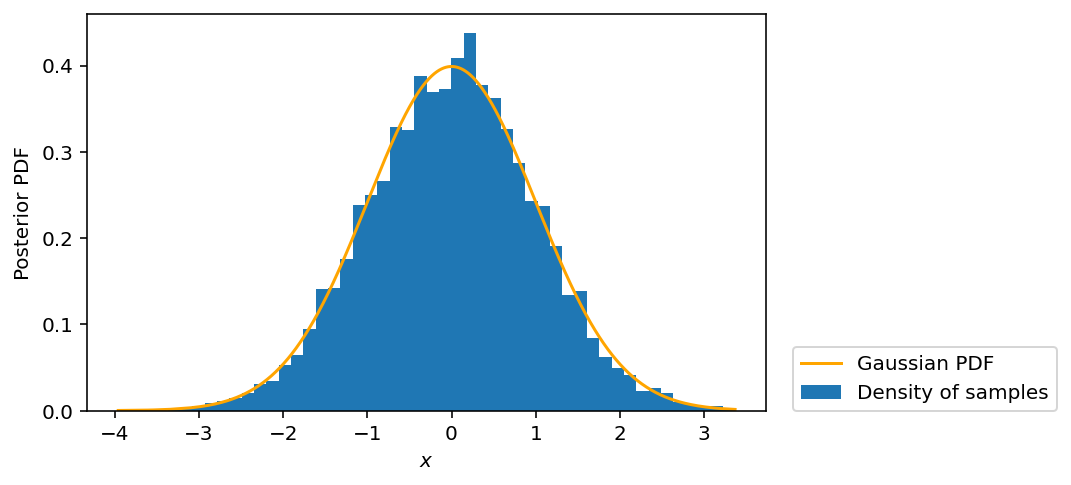

In [32]:
samples_from_normal = np.random.normal(size=10000)
sorted_samples = np.sort(samples_from_normal)
Gaussian_pdf = norm.pdf(sorted_samples)
plt.hist(samples_from_normal,density=True,bins=50,label='Density of samples')
plt.plot(sorted_samples, Gaussian_pdf, c='orange',label='Gaussian PDF')

plt.xlabel("$x$")
plt.ylabel("Posterior PDF")
plt.legend(loc=(1.04,0))


In-built functions like this typically use "Inverse CDF sampling" or "Inverse Transform Sampling". Briefly, the inverse transform sampling method hinges on our computer's ability to sample uniformly on the unit interval well. A sample can easily be drawn between [0,1] and then mapped onto a random variable using the CDF (cumulative distirbution function). For example, for the Poisson distribution:


<img src="https://docs.google.com/uc?export=download&id=1JV36YvvpnCvuQIKSVfH2pBEplmsJKpAQ" width="400">


This easily generates samples from 1D distributions where we can already construct the CDF. However, we don't know the PDF $\textit{or}$ CDF for general, data-driven distributions like the ones we have.

How do we sample an arbitrary, multi-dimensional posterior PDF? i.e., one that does not admit a neat, closed-form expression. There are many answeres to this question, but a widely-used solution is to turn to "Monte Carlo" sampling methods, such as Markov Chain Monte Carlo (MCMC) and Nested Sampling.

MCMC is typically used only to generate samples from the posterior: it is not well adapted to esimating the evidence, so isn't usually used to perform model selection. An algorithm called $\textbf{nested sampling}$ is designed specifically to estimate the evidence, but also produces posterior sampels as a byproduct. 


# Estimating the posterior and evidence using Nested Sampling 


The outputs of nested sampling are 

* an N-dimensional list which can be, e.g., histogrammed to form the probability density. We can also easily obtain the marginalized 1-D, 2-D, etc... distributions by histogramming specific columns of the list.

* The evidence of the data under an hypothesis

Without getting bogged down in details, let's look at how this works in practice by using a well road-tested, off-the-shelf package: $\texttt{dynesty}$. Our goal here is to use $\texttt{dynesty}$ like we would call something like $\texttt{numpy.random.normal()}$. Once we have run the algorithm, we'll inspect the output and results to build intuition for high-dimensional samples.

### Our objective

We wish to obtain samples $\{\theta\}$ drawn from the posterior distribution $p(\theta | d, \mathcal{H}_S) $-- analagous to x in the histogram above -- where $\mathcal{H}_S$, and the data $d$ are defined in the code snippet at the start of the notebook.

* Each sample $\theta_i$ is a 3-dimensional tuple 
  * $\theta = (m_1, m_2, D)$
  * The density of sample points should reflect the underlying probability density which we can't evaluate directly because of the "curse of dimensionality"
  
Example output is shown below:
  
  <img src="https://docs.google.com/uc?export=download&id=1-RStwHoNMkyIOtQsLM9ljk9PUTZyNo8K" width="400">

We also want to perform hypothesis testing to determine if the data are better described by a "signal hypothesis" or a "noise hypothesis".

Recall that the Bayes factor is 

* $B_{S,N}=\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$

with

$Z(d|\mathcal{H}_S) = \int d\theta\, \pi(\theta) \mathcal{L}(d|\theta, \mathcal{H}_S)$


Nested sampling overcomes the curse using sampling to estimate the evidence 

## Nested Sampling




The main idea behind nested sampling (Skilling 2006) is to find the "area under the curve". Recall that 

$\text{posterior} \times \text{evidence}$ = $\text{likelihood} \times \text{prior}$



The integral over the posterior is 1 (it's a normalized probability distribution) so the evidence is just the integral of the $\text{likelihood} \times \text{prior}$ over the parameter space.

Nested sampling is an algorithmic approach which works by finding nested contours of likelihood that enclose increasingly higher fractions of prior-probability. Once we have enclosed all of the prior probability, we should have found all of the area under the curve. 


Again, the exact details are not our main concern here, though I encourage you to read deeper into the details of the algorithm. Here, we will look at a practical application and it suffices to know that there is an implementation which we can use to find the evideces for our data given various hypotheses. 

A byproduct of nested sampling are the posterior samples which tell us about the astrophysical parameters of the signal.


#  Worked Example
##Defining the target probability distribution 

In the language of Bayesian inference, we can construct a posterior PDF on the parameters $\theta$ given our hypothesis $\mathcal{H}_S$ -- the data contain a signal :


---


$p(\theta | d, \mathcal{H}_S) = \frac{\pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_S)}{Z(d|\mathcal{H}_S)}$


---


The LHS is the four-dimensional posterior PDF. On the LHS are: 

* The Prior $\pi(\theta)$
* The Likelihood of the data under the signal hypothesis $\mathcal{L}(d|\theta,\mathcal{H}_S)$
* The Evidence that the data contain a signal $Z(d|\mathcal{H}_S)$

Recall that samples are just draws from a probability distribution. They can be, e.g., histogrammed to construct the probability density function. For instance, in 1D, we used $\texttt{numpy}$ function $\texttt{np.random.rand()}$ to generate $N$ random "noise" variables, distributed according to a normal distribution. If we histogram the noise, we should see that the density of points is the Gaussian PDF:

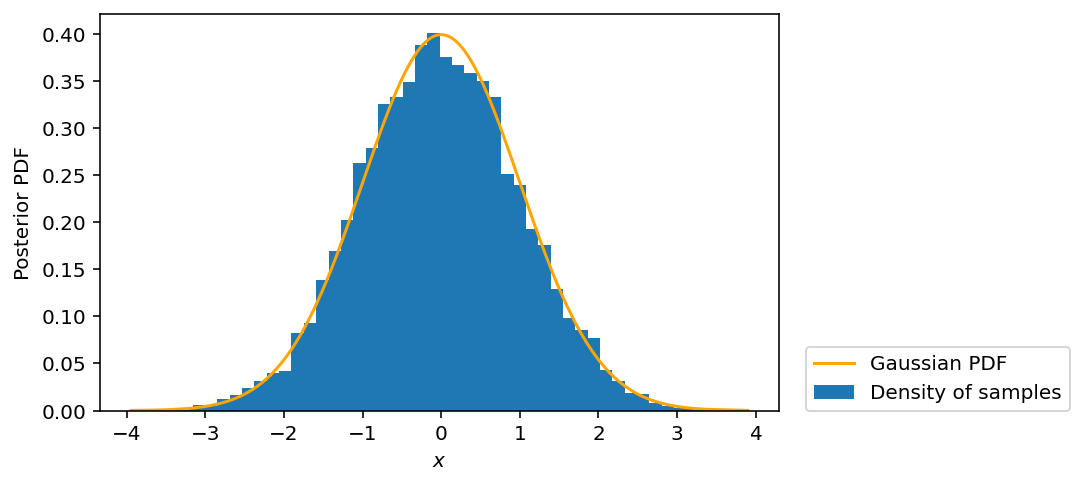

In [33]:
samples_from_normal = np.random.normal(size=10000)
sorted_samples = np.sort(samples_from_normal)
Gaussian_pdf = norm.pdf(sorted_samples)
plt.hist(samples_from_normal,density=True,bins=50,label='Density of samples')
plt.plot(sorted_samples, Gaussian_pdf, c='orange',label='Gaussian PDF')

plt.xlabel("$x$")
plt.ylabel("Posterior PDF")
plt.legend(loc=(1.04,0))

## Constructing the elements of the posterior

To evaluate the posterior, 

$p(\theta | d, \mathcal{H}_S) = \frac{\pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_S)}{Z(d|\mathcal{H}_S)}$

we will need to write down a prior 

$\pi(\theta)$

and a likelihood function. 

$\mathcal{L}(d|\theta,\mathcal{H}_S)$





### The prior

Starting with the prior, let's assume our usual uniform distribution on each of the four $\textit{a priori}$ unknown parameters bundled in $\theta$:


---


* $\pi(m_1) = \text{Uniform}(25M_{\odot},40M_{\odot})$
* $\pi(m_2) = \text{Uniform}(25M_{\odot},40M_{\odot})$
* $\pi(D) = \text{Uniform}(400\text{Mpc},600\text{Mpc})$


* $\pi(\theta) = \pi(m_1)\pi(m_2)\pi(D)$

* $m_1 > m_2$

---


Outside of the ranges specified, the probabiltiy will assumed to be zero.

Note that the product of priors follows from the assumption that the parameters are independent/uncorrelated


### The likelihood

The assuptions that form our model for the data are 



Our likelihood for the signal model (see Lecture 2) is 


---


* $\mathcal{L}(d|\theta, \mathcal{H}_S) = \prod_k \Big[\text{Normal}_{\text{PDF}}(\text{Re}\, \left[d_k\right]; \mu=s_k(\theta),\sigma) \times \text{Normal}_{\text{PDF}}(\text{Im}\, \left[d_k \right]; \mu=s_k(\theta),\sigma)\Big]$


---
and the product follows from the independence of the data at each frequency

In [44]:

def ln_like_for_nest(theta):

        m1,m2,D = theta[0],theta[1],theta[2]
  
        signal = frequency_domain_GWsignal(m1,m2,D)
                
        log_L_real = np.sum( norm.logpdf(data.real, \
                                         loc=signal.real, scale=np.sqrt(psd/(4*df))) )
      
        log_L_imag = np.sum( norm.logpdf(data.imag, \
                                         loc=signal.imag, scale=np.sqrt(psd/(4*df))) )
    
        return log_L_real+log_L_imag

### The (un-normalized) posterior

* $p(\theta | d, \mathcal{H}_S) \propto \pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_S)$

Let's define  our singal model as a function of :


---


* the primary mass $m_1(M_{\odot})$, 
* The secondary mass $m_2(M_{\odot})$
* The distance to the source $D(\text{Mpc})$ 

and we bundle the mass and distance into the vector $\theta$

* $\theta = (m_1, m_2, D)$


---


The function is defined below (notice that it's almost the same as the function we saw in Lecture 2). The function takes as input two masses and return a sum of $\tilde{h}_{+}$ and $\tilde{h}_{\times}$, i.e., the output is a Fourier domain strain


---


* $\tilde{h}(\theta;f) = \tilde{h}_{+}+\tilde{h}_{\times}$


---


The other parameters which catagorize the source are fixed to the values defined within the function. 

* The other parameter values are fixed to the true values of the signal contained in the data.

The frequency range over which the signal is defined is :

* $0\text{Hz} \leq f \leq 2048\text{Hz} $

and the signal has no content below $f=20$Hz (this is unphysical, but it is equivalent to saying that we don't care about the content of the signal below $20$Hz)

# Putting the pieces together: Estimating the Posterior and Evidence with nested sampling

In [45]:
import dynesty
from dynesty import plotting as dyplot


## Parameter Estimation



From the user's perspective, the packages $\texttt{emcee}$ and $\texttt{dynesty}$ work almost identically. Two exceptions are that $(i)$ $\texttt{dynesty}$ has stopping criterion based on the convergence of the evidence, and $(ii)$ $\texttt{dynesty}$ samples in "auxiliary variables" rather than the intrinsic parameters we care about. The latter point is more of a subtlety that's easy to overcome in practice. We won't dwell on this much, but briefly: $\texttt{dynesty}$ samples Uniformly on the N-dimensional unit hypercube. Samples from the hyper cube have to be mapped onto the real parameter space using a $\texttt{prior transform}$ function, shown below.

In [55]:
def prior_transform(utheta):
    
    um1, um2, ud = utheta # these are samples from the unit hyper cube
    # the "prior transform" below maps the unit-cube samples to the 
    # parameters we care about 
    
    # Think of this as the result of performing the inverse CDF. The 
    #specific mapping here maps uniformly distributed samples 
    #(on the hypercube) to uniformly distributed samples
    # on the correct intervals
    m_min = 25
    m_max = 40
    D_min = 400
    D_max = 600
    m1 = (m_max - m_min) * um1 + m_min
    m2 = (m_max - m_min) * um2 + m_min
    D = (D_max - D_min) * ud + D_min
    
    return m1,m2,D


In [ ]:
dsampler = dynesty.NestedSampler(ln_like_for_nest, prior_transform, ndim=3,
                                        nlive=500)
dsampler.run_nested(dlogz=0.1)
dres = dsampler.results

1299it [00:14, 36.75it/s, bound: 0 | nc: 3 | ncall: 7351 | eff(%): 17.671 | loglstar:   -inf < 833063.599 <    inf | logz: 833055.066 +/-  0.127 | dlogz: 648.757 >  0.100] 

In [ ]:
labels=[r"$m_1(M_{\odot})$", r"$m_2(M_{\odot})$", r"$D(\mathrm{Mpc})$"]
truths=[30.,30.,1500]

#fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
#                             labels=labels,quantiles=[0.05,0.95])
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                             labels=labels,quantiles=[0,1])
plt.show()
#plt.savefig("/content/gdrive/My Drive/InvisibleUniverse/images/corner_dynesty.png",bbox_inches='tight',dpi=100)

In [ ]:
logz_signal_hypothesis = dres['logz'][-1]
print (logz_signal_hypothesis)


853797.3666526382


The (log) signal-evidence is 

* $\ln Z(d|\mathcal{H}_S) = 853797.4$

## Model selection: signal or noise?


The (log) noise-evidence (from lecture 1) is 

* $\ln Z(d|\mathcal{H}_N) = 853195.3$

The Odds Ratio compares the odds that the data are consistent with the signal or noise hypothesis. Recall that we have 

* $O_{S,N}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$


Let's assume that we have equal prior odds for the signal and noise hypotheses so that:

* $P(\mathcal{H}_S|I) = P(\mathcal{H}_N|I)$

The Odds ratio is then just a ratio of the evidences we just computed:

* $O_{S,N}=\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$

Inserting the values we just computed:

* $\ln Z(d|\mathcal{H}_S) = 853797.4$
* $\ln Z(d|\mathcal{H}_N) = 853195.3$

Giving 

* $\ln O_{S,N}=853797.4 - 853195.3 = 602.1$


And we find that we overwhelmingly favor the signal hypothesis over the noise hypothesis! 

## Uncertainty quantification 

In statistics, it is customary to summarize measurements in terms of "summary statistics". For instance, means, variances, skewness, etc...This is unnecessary, and often fails to capture subtleties in the underlying distributions. For example, it may be misleading to quote the mean and variance of a bimodal distribution, e.g.,

In [ ]:
def bimodal():
    
    frac = 0.3
    samps = np.zeros(10000)
    
    for i in range(len(samps)):
    
        cointoss = np.random.uniform()
        if cointoss > frac:
            samps[i] = np.random.normal(loc=10,scale=4)
        else:
            samps[i] = np.random.normal(loc=0,scale=2)
            
    return samps



Text(0,0.5,'Posterior PDF')

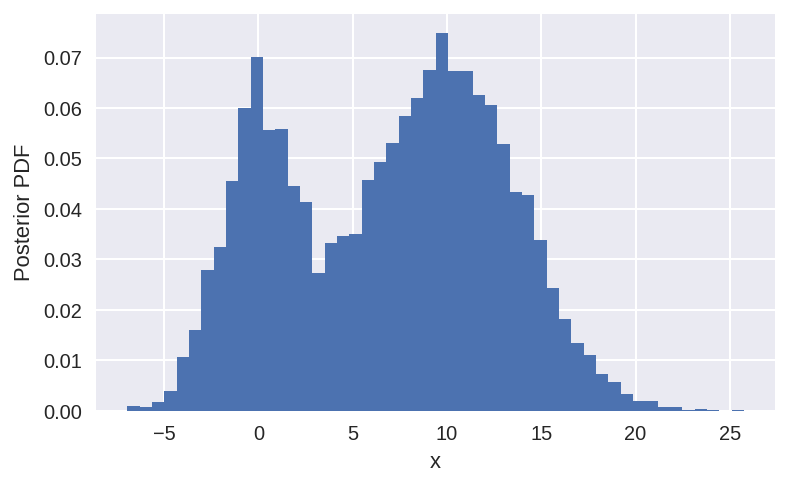

In [ ]:
plt.hist(bimodal(), bins=50, density=True)
plt.xlabel("x")
plt.ylabel("Posterior PDF")

If our "measurement" consists of a posterior density function, we want to be able to describe as many features of the measurement as possible. Ideally, we shouldn't have to fall back on summary statistics that might only be applicable to simple distributions that don't represent our measurement well. However, it is usually customary to define a region of probability known as the "credible interval" (CI). The $X\%$ credible interval is the region about a point (e.g., the median) that contains $X\%$ of the probability. There are numerous ways to define such an interval, and it need not be symmetric. Usually, one picks a point, e.g., the median of the distribution, and integrates left and right until $X\%$ of the probability under the curve has been found. 

We can easily display these intevals using $\texttt{corner}$ in the following way. For instance, for the $90\%$ credible intervals

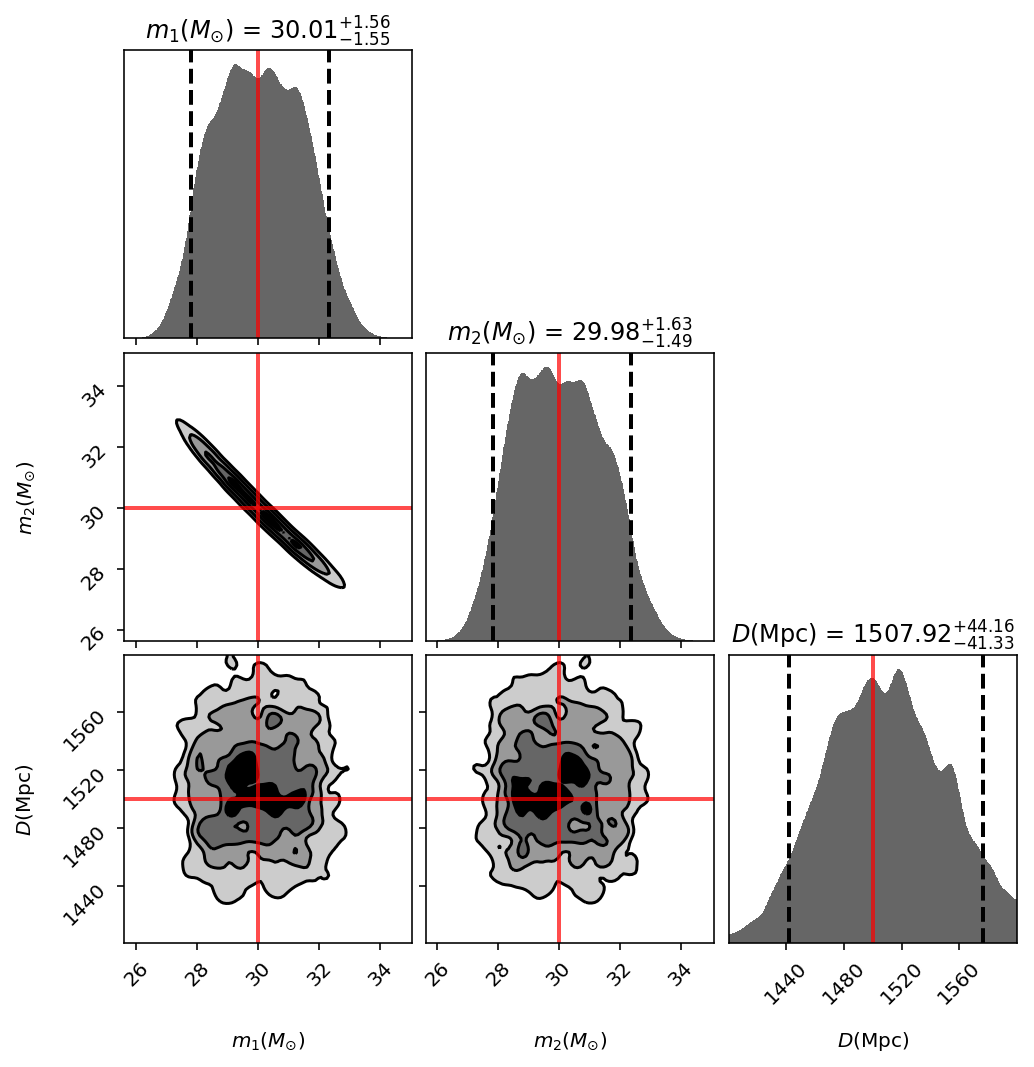

In [ ]:
labels=[r"$m_1(M_{\odot})$", r"$m_2(M_{\odot})$", r"$D(\mathrm{Mpc})$"]
truths=[30.,30.,1500]

fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                             labels=labels,quantiles=[0.05,0.95])


We used the $\texttt{quantiles}=[0.05,0.95]$ argument to specify that we want to highlight the region in which $90\%$ of the probability is contained. The argument $\texttt{levels}=[0.5,0.75,0.9]$ produces the $50\%, 75\%$ and $90\%$ credible intervals on the 2D marginalized PDFs.  

The CI has a natural interpretation. If our likelihood is unbiased (meaning our signal and noise models are accurate) then we should expect the "true" parameter values to fall within the $X\%$ CI in exactly $X\%$ of the realizations of the data. Different noise realizations yield different PDFs.

# Summary


* Implemented nested sampling to:
    * Estimate evidences
    * Compute Odds ratios
    * Perform hypothesis testing

# Suggested topics for futher reading

## User-friendly parameter estimation libraries

[Bilby](https://git.ligo.org/lscsoft/bilby)

And [the paper](https://arxiv.org/abs/1811.02042)

## Sampling methods 

* Hamiltonian MCMC
    * Physics-inspired sampling techniques that can be more efficient at exploring the parameter space, e.g., STAN https://mc-stan.org/
    

## Approximate methods 



* Variational Bayes
    * Optimization based on variational methods. Gives a lower bound on evidences, e.g., Edward http://edwardlib.org/

## Probabilistic programing

e.g., Edward http://edwardlib.org/